In [4]:
from torchvision import datasets
data_path = '../../../../../data/02.cv/cifar-10/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True) # <1>
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True) # <2>

Files already downloaded and verified
Files already downloaded and verified


In [6]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

训练集大小: 50000
验证集大小: 10000
样本标签: 6


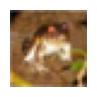

In [17]:
# 查看数据集的大小
print(f"训练集大小: {len(cifar10)}")
print(f"验证集大小: {len(cifar10_val)}")

# 查看单个样本
image, label = cifar10[0]
print(f"样本标签: {label}")

fig = plt.figure(figsize=(1,1))

# 显示缩放后的图像
plt.imshow(image)
plt.axis("off")
plt.show()

图像大小: (32, 32)


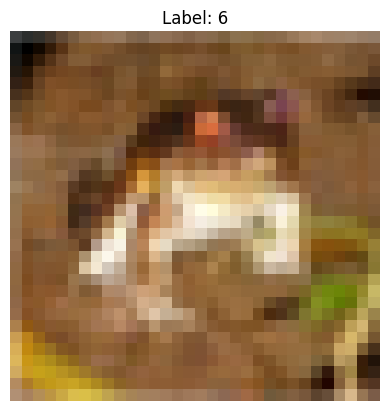

In [12]:
# 查看图像尺寸
print(f"图像大小: {image.size}")  # 输出为 (宽, 高)，即 (32, 32)

# 显示原始图像
image.show()  # 使用系统默认图像查看器
# 或用 Matplotlib 显示
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis("off")
plt.title(f"Label: {label}")
plt.show()

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

# 超参数设置
latent_dim = 100
batch_size = 128
num_epochs = 100
lr = 0.0002
beta1 = 0.5
image_size = 32

# CIFAR-10 数据预处理和加载
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class FrogDataset(Dataset):
    def __init__(self, dataset):
        self.data = [img for img, label in dataset if label == 6]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

train_dataset = torchvision.datasets.CIFAR10(root='../../../../../data/02.cv/cifar-10/', train=True, download=True, transform=transform)
frog_dataset = FrogDataset(train_dataset)
train_loader = DataLoader(frog_dataset, batch_size=batch_size, shuffle=True)

# 定义生成器
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False)  # 输出为 [batch_size, 1, 1, 1]
        )

    def forward(self, img):
        out = self.model(img)  # 输出形状: [batch_size, 1, 1, 1]
        return out.view(-1)  # 展平为 [batch_size]


# 初始化模型
generator = Generator(latent_dim).cuda()
discriminator = Discriminator().cuda()

# 损失函数和优化器
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

for epoch in range(num_epochs):
    for i, imgs in enumerate(train_loader):
        imgs = imgs.cuda()

        # 标签生成
        real = torch.ones(imgs.size(0)).cuda()  # [batch_size]
        fake = torch.zeros(imgs.size(0)).cuda()  # [batch_size]

        # 训练判别器
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(imgs), real)  # 判别真实图片
        z = torch.randn(imgs.size(0), latent_dim, 1, 1).cuda()  # 随机噪声
        gen_imgs = generator(z)  # 生成图片
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)  # 判别生成图片
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # 训练生成器
        optimizer_G.zero_grad()
        g_loss = adversarial_loss(discriminator(gen_imgs), real)  # 希望生成图片被判别为真实
        g_loss.backward()
        optimizer_G.step()

    print(f"[Epoch {epoch+1}/{num_epochs}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

    # 每隔一定周期保存生成的图片
    if epoch % 10 == 0:
        torchvision.utils.save_image(gen_imgs.data[:25], f"output_epoch_{epoch}.png", nrow=5, normalize=True)


Files already downloaded and verified


RuntimeError: Calculated padded input size per channel: (2 x 2). Kernel size: (4 x 4). Kernel size can't be greater than actual input size

In [22]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim, channels):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        
        self.model = nn.Sequential(
            # 输入层，将latent_dim映射为 128 x 16 x 16 的特征图
            nn.Linear(latent_dim, 128 * 16 * 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (128, 16, 16)),

            # 卷积层，保持 16x16 特征图大小
            nn.Conv2d(128, 256, kernel_size=5, padding=2),
            nn.LeakyReLU(0.2, inplace=True),

            # 转置卷积层，上采样到 32x32
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # 连续两层卷积，保持 32x32 特征图大小
            nn.Conv2d(256, 256, kernel_size=5, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, kernel_size=5, padding=2),
            nn.LeakyReLU(0.2, inplace=True),

            # 输出层，生成具有指定通道数的图像
            nn.Conv2d(256, channels, kernel_size=7, padding=3),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# 测试生成器
latent_dim = 32
channels = 3

# 初始化生成器
generator = Generator(latent_dim, channels)
generator = generator.cuda() if torch.cuda.is_available() else generator
print(generator)

# 输入随机噪声，生成样本
z = torch.randn(1, latent_dim).cuda() if torch.cuda.is_available() else torch.randn(1, latent_dim)
gen_imgs = generator(z)
print("Generated image shape:", gen_imgs.shape)

Generator(
  (model): Sequential(
    (0): Linear(in_features=32, out_features=32768, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Unflatten(dim=1, unflattened_size=(128, 16, 16))
    (3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 3, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (12): Tanh()
  )
)
Generated image shape: torch.Size([1, 3, 32, 32])


In [23]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, height=32, width=32, channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # 第一层卷积
            nn.Conv2d(channels, 128, kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(0.2, inplace=True),

            # 第二层卷积，步幅为2，降采样
            nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=0),
            nn.LeakyReLU(0.2, inplace=True),

            # 第三层卷积，步幅为2，进一步降采样
            nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=0),
            nn.LeakyReLU(0.2, inplace=True),

            # 第四层卷积，步幅为2，进一步降采样
            nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=0),
            nn.LeakyReLU(0.2, inplace=True),

            # 展平为一维向量
            nn.Flatten(),

            # Dropout层，防止过拟合
            nn.Dropout(0.4),

            # 全连接层，用于最终判别
            nn.Linear(128 * ((height // 16) * (width // 16)), 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 示例使用
height, width, channels = 32, 32, 3
discriminator = Discriminator(height, width, channels)
print(discriminator)


Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2))
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Dropout(p=0.4, inplace=False)
    (10): Linear(in_features=512, out_features=1, bias=True)
    (11): Sigmoid()
  )
)


# 11

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils

# 定义生成器网络
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # 全连接层，展平为 (128, 128, 8, 8)
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (128, 8, 8)),  # 将 (batch, 128*8*8) 转换为 (batch, 128, 8, 8)
            # 第一次上采样，(128, 8, 8) -> (128, 16, 16)
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 第二次上采样，(128, 16, 16) -> (128, 32, 32)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # 输出通道调整到 3，(64, 32, 32) -> (3, 32, 32)
            nn.Conv2d(64, img_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # 输出范围在 [-1, 1]
        )

    def forward(self, z):
        return self.model(z)

        
# 定义判别器网络
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels, 128, 3, padding=1),  # 输入 (3, 32, 32) -> (128, 32, 32)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, 4, stride=2, padding=1),  # (128, 32, 32) -> (128, 16, 16)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, 4, stride=2, padding=1),  # (128, 16, 16) -> (128, 8, 8)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, 4, stride=2, padding=1),  # (128, 8, 8) -> (128, 4, 4)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),  # 展平 -> (128, 2048)
            nn.Dropout(0.4),
            nn.Linear(128 * 4 * 4, 1),  # 将 `in_features` 调整为 2048
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)



# 参数设置
latent_dim = 32
channels = 3
image_size = 32
batch_size = 128
epochs = 100
lr = 0.0002

# 数据加载和预处理
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.CIFAR10(root='../../../../../data/02.cv/cifar-10/', download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 初始化模型
generator = Generator(latent_dim, channels).cuda()
discriminator = Discriminator(channels).cuda()

# 损失函数和优化器
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# 开始训练
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(data_loader):
        imgs = imgs.cuda()

        # 创建真实标签和假标签
        real_labels = torch.ones(imgs.size(0), 1).cuda()
        fake_labels = torch.zeros(imgs.size(0), 1).cuda()

        # 训练判别器
        z = torch.randn(imgs.size(0), latent_dim).cuda()
        fake_imgs = generator(z)
        
        real_loss = criterion(discriminator(imgs), real_labels)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = real_loss + fake_loss

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # 训练生成器
        g_loss = criterion(discriminator(fake_imgs), real_labels)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # 打印日志
        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i}/{len(data_loader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    # 每个epoch保存生成的图片
    fake_imgs = fake_imgs.view(fake_imgs.size(0), channels, image_size, image_size)
    vutils.save_image(fake_imgs[:25], f"output_epoch_{epoch+1}.png", nrow=5, normalize=True)


Files already downloaded and verified
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 1])
torch.Size([128, 1])
Epoch [1/100], Step [0/391], D Loss: 1.3854, G Loss: 0.6990
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 1])
torch.Size([128, 1])
to

KeyboardInterrupt: 

# 22

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils

# 定义生成器网络
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # 1. 全连接层：将潜在向量 (latent_dim) 投影并展平为形状 (128, 8, 8)
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (128, 8, 8)),  # 转换为形状 (batch, 128, 8, 8)

            # 2. 转置卷积层：第一次上采样，(128, 8, 8) -> (128, 16, 16)
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # 3. 转置卷积层：第二次上采样，(128, 16, 16) -> (64, 32, 32)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # 4. 卷积层：输出通道调整为图像通道数 (64, 32, 32) -> (3, 32, 32)
            nn.Conv2d(64, img_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # 将输出范围限制在 [-1, 1]
        )

    def forward(self, z):
        return self.model(z)

# 定义判别器网络
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # 1. 卷积层：初始通道从图像通道数增加到 128，(3, 32, 32) -> (128, 32, 32)
            nn.Conv2d(channels, 128, 3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # 2. 卷积层：下采样，(128, 32, 32) -> (128, 16, 16)
            nn.Conv2d(128, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # 3. 卷积层：下采样，(128, 16, 16) -> (128, 8, 8)
            nn.Conv2d(128, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # 4. 卷积层：下采样，(128, 8, 8) -> (128, 4, 4)
            nn.Conv2d(128, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # 5. 展平层：将 (128, 4, 4) 展平为向量 (128 * 4 * 4)
            nn.Flatten(),
            nn.Dropout(0.4),  # 添加 Dropout 防止过拟合

            # 6. 全连接层：映射到单个输出值 (即概率)
            nn.Linear(128 * 4 * 4, 1),
            nn.Sigmoid()  # 使用 Sigmoid 输出范围在 [0, 1]
        )

    def forward(self, img):
        return self.model(img)

# 参数设置
latent_dim = 32  # 潜在向量维度
channels = 3  # 图像通道数（彩色图像为 3）
image_size = 32  # 图像尺寸 (32x32)
batch_size = 128  # 每批数据大小
epochs = 100  # 训练轮数
lr = 0.0002  # 学习率

# 数据加载和预处理
transform = transforms.Compose([
    transforms.Resize(image_size),  # 调整图像尺寸
    transforms.ToTensor(),  # 转换为 PyTorch 张量
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 归一化到 [-1, 1]
])

dataset = datasets.CIFAR10(root='../../../../../data/02.cv/cifar-10/', download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 初始化模型
generator = Generator(latent_dim, channels).cuda()
discriminator = Discriminator(channels).cuda()

# 损失函数和优化器
criterion = nn.BCELoss()  # 二分类交叉熵损失
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# 开始训练
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(data_loader):
        imgs = imgs.cuda()  # 将数据移动到 GPU

        # 创建真实标签和假标签
        real_labels = torch.ones(imgs.size(0), 1).cuda()  # 真实图像标签为 1
        fake_labels = torch.zeros(imgs.size(0), 1).cuda()  # 生成图像标签为 0

        # 训练判别器
        z = torch.randn(imgs.size(0), latent_dim).cuda()  # 从标准正态分布中采样潜在向量
        fake_imgs = generator(z)  # 使用生成器生成假图像

        real_loss = criterion(discriminator(imgs), real_labels)  # 判别器对真实图像的损失
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)  # 判别器对假图像的损失
        d_loss = real_loss + fake_loss  # 判别器总损失

        d_optimizer.zero_grad()  # 清空梯度
        d_loss.backward()  # 反向传播
        d_optimizer.step()  # 更新判别器参数

        # 训练生成器
        g_loss = criterion(discriminator(fake_imgs), real_labels)  # 生成器希望生成的图像被判别为真实

        g_optimizer.zero_grad()  # 清空梯度
        g_loss.backward()  # 反向传播
        g_optimizer.step()  # 更新生成器参数

        # 打印日志
        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i}/{len(data_loader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    # 每个 epoch 保存生成的图片
    fake_imgs = fake_imgs.view(fake_imgs.size(0), channels, image_size, image_size)
    vutils.save_image(fake_imgs[:25], f"output_epoch_{epoch+1}.png", nrow=5, normalize=True)

Files already downloaded and verified
Epoch [1/100], Step [0/391], D Loss: 1.3855, G Loss: 0.6966
Epoch [1/100], Step [50/391], D Loss: 1.3103, G Loss: 0.8835
Epoch [1/100], Step [100/391], D Loss: 1.2646, G Loss: 0.8451
Epoch [1/100], Step [150/391], D Loss: 1.3148, G Loss: 0.5637
Epoch [1/100], Step [200/391], D Loss: 1.2801, G Loss: 0.8403
Epoch [1/100], Step [250/391], D Loss: 0.6769, G Loss: 1.4675
Epoch [1/100], Step [300/391], D Loss: 1.3419, G Loss: 1.2702
Epoch [1/100], Step [350/391], D Loss: 1.3523, G Loss: 0.8073
Epoch [2/100], Step [0/391], D Loss: 1.4065, G Loss: 0.7933
Epoch [2/100], Step [50/391], D Loss: 1.3863, G Loss: 0.8207
Epoch [2/100], Step [100/391], D Loss: 1.2818, G Loss: 0.8185
Epoch [2/100], Step [150/391], D Loss: 1.2643, G Loss: 0.7714
Epoch [2/100], Step [200/391], D Loss: 1.3200, G Loss: 0.8439
Epoch [2/100], Step [250/391], D Loss: 1.3093, G Loss: 0.7690
Epoch [2/100], Step [300/391], D Loss: 1.3448, G Loss: 0.7753
Epoch [2/100], Step [350/391], D Loss:

KeyboardInterrupt: 

In [36]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim, channels):
        super(Generator, self).__init__()

        self.latent_dim = latent_dim

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 16 * 16),  # 全连接层，生成16*16*128的特征图
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (128, 16, 16)),  # 重塑为特征图

            nn.Conv2d(128, 256, kernel_size=5, padding=2),  # padding='same' -> padding=2
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1),  # 上采样为32x32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 256, kernel_size=5, padding=2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 256, kernel_size=5, padding=2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, channels, kernel_size=7, padding=3),  # 输出图像，padding=3保持输出尺寸不变
            nn.Tanh()  # 输出激活函数
        )

    def forward(self, x):
        return self.model(x)

# 参数定义
latent_dim = 32
height = 32
width = 32
channels = 3

# 测试生成器
generator = Generator(latent_dim, channels)
generator_input = torch.randn(1, latent_dim)  # 假设一个batch，batch_size=1
output = generator(generator_input)

print(generator)
print(f"Output shape: {output.shape}")


Generator(
  (model): Sequential(
    (0): Linear(in_features=32, out_features=32768, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Unflatten(dim=1, unflattened_size=(128, 16, 16))
    (3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 3, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (12): Tanh()
  )
)
Output shape: torch.Size([1, 3, 32, 32])


In [37]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(channels, 128, kernel_size=3),  # 输出维度: (batch_size, 128, height-2, width-2)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 128, kernel_size=4, stride=2),  # 输出维度: (batch_size, 128, (height-2-3)//2 + 1, (width-2-3)//2 + 1)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 128, kernel_size=4, stride=2),  # 输出维度: (batch_size, 128, (previous_height-3)//2 + 1, (previous_width-3)//2 + 1)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 128, kernel_size=4, stride=2),  # 输出维度: (batch_size, 128, ...)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),  # 展平，适配全连接层

            nn.Dropout(0.4),  # Dropout层

            nn.Linear(128 * 4 * 4, 1),  # 假设最终特征图为4x4，调整输入维度
            nn.Sigmoid()  # Sigmoid激活函数
        )

    def forward(self, x):
        return self.model(x)

# 参数定义
height = 32
width = 32
channels = 3

# 测试判别器
discriminator = Discriminator(channels)
discriminator_input = torch.randn(1, channels, height, width)  # 假设一个batch，batch_size=1
output = discriminator(discriminator_input)

print(discriminator)
print(f"Output shape: {output.shape}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x512 and 2048x1)